# Examine the Competitiveness

In [1]:
import pandas as pd
import sys
import warnings
import numpy as np

from IPython.display import display

warnings.filterwarnings('ignore')
sys.path.append('../')

from src.visualizations import plot_median_target_by_group
from src.metrics import competitiveness_index


In [2]:
# we will continue to use subset as our dataset
# The main reason is we want a bigger picture free of outliers, or/and NA values
# Plus as mentioned before the dataset consists a very decent representation of the market at this point

mdata = pd.read_csv('../data/subset.csv')

In [3]:
def numeric_floor(df):

    mlist = []
    for x in range(len(df)):
        if df['floor'][x] == 'ground-floor':
            mlist.append(0.0)
        elif df['floor'][x] == 'basement':
            mlist.append(-1.0)
        elif df['floor'][x] == 'semi-basement':
            mlist.append(-.5)
        elif df['floor'][x] == 'mezzanine':
            mlist.append(.5)
        else:
            mlist.append(float(df['floor'][x]))

    df['floor'] = pd.Series(mlist)
    return df


mdata = numeric_floor(mdata)

In [4]:
mdata.columns

Index(['id', 'ranking_score', 'geography_name', 'sq_meters', 'price',
       'year_of_construction', 'ad_type', 'floor', 'rooms', 'subtype',
       'price_per_sqrm'],
      dtype='object')

### Price based approach

One of the most important factor of a property is it's price. Therefore, we approached this issue by grouping the properties according to areas, and the number of rooms.
The next 2 graphs show the median value of a property listed and it's standard deviation as error bar.

If for example a property is listed for a price per square meter way higher than it's matchings then that can be a reason for it's low competitiveness.

Similarly the price per squaremeter should be matched accordingly to which floor the condo is, or how many rooms it has.

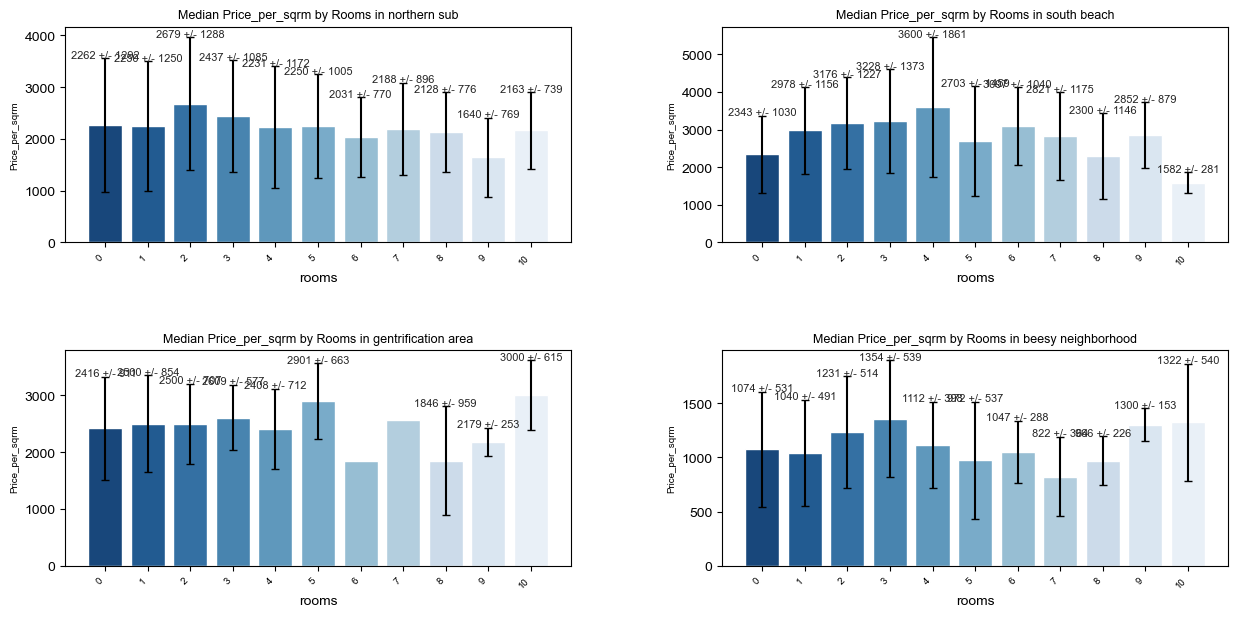

In [5]:
plot_median_target_by_group(mdata,big_group='geography_name',small_group='rooms',target='price_per_sqrm',fig_size=[15,7])

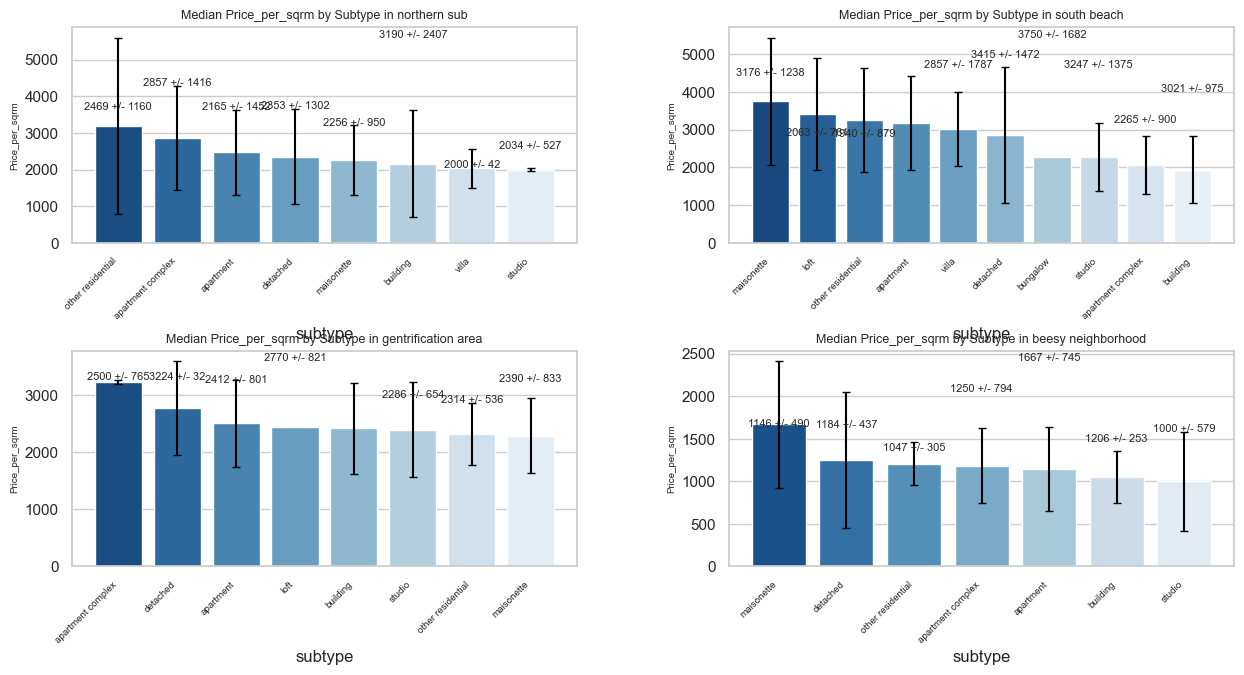

In [6]:
plot_median_target_by_group(mdata,fig_size=[15,7])

### Competitiness as index

We will try to approach the issue by making a simple index that simulates the competitiveness of a property.

In any case this index can be more complex and accurate but we will keep it this way just for the purpose of the assignment. 

We will also set a methodological approach that could result in a better index but it's not going to be implemented in this assignment

To create this index we will a combination of attributes such as:

$Competitiveness (C) = F \times W $ where $F$ is a matrix that holds all the variables and $W$ a matrix with the weights

 - $Floor$ For this factor everything will remain as is with the exception that everything above 3rd floor will have a weight of 3. This happends due to the reason that 3rd floor and above will not significantly change the safety issue and the comfortness compared to a basement etc.
 - $Rooms$ will follow an expontenial increase, as the greater number the more likely someone will be interested for the property. the function will follow the rule as:
 
    $y = a_0 * (1+r)^t$ where $a_0 =1$ and $r = n_{rooms}$ and $t=1.5$, that indicates that for each extra room there is 50% more interest than before
 - $Price-Deviation (D)$ from median. This Factor will indicate how much higher or lower from the median value of the area a property is listed for. Thereby, the function that will describe that is:
 
   $ X_{norm} : (X_{median} - x_i)^2 \text{for each area}$, in other words it will be the normalized euclidean distance from median to existing value, similarly implemented for $MSE$

- $Ad$ type. This factor will have just 4 different categories as $ 0 = simple, up = 1, star = 2, premium = 3$

- $Year of Construction$ We will naively implement 3 categories, old premises, middle to average and new ones. Everything before 1970 will be old, mid will be the 1970 - 2000, and everything after 2000 will be the new ones. Factors will be set as $ [2, 1, -2]$


**footnote**
Note that the competitiveness index formula described above was developed for the purpose of this assignment and may not reflect the full complexity of the market. Due to the time constraints of the assignment, some of the assumptions and weights used in the formula may be naive or oversimplified. Therefore, the results of the competitiveness index should be viewed as exploratory and further investigation may be necessary to validate the assumptions and refine the formula.

In [7]:
# We will use some arbitary weights for each factor
# Preassumption 20% in Floor (Villas can be at 0 floor)
# Rooms 30%
# Price Deviation 15% (a good property can attract high level buyers)
# Ad type: 15% the more someone sees an ad the highest the probability however, if the property does not fit standard ad cant do the work on its own
# Year: 20% a well respected factor for finding a property

weights = np.array([0.20, 0.30, 0.15, 0.15,0.2])
vis_df = competitiveness_index(mdata, weights=weights).reset_index(drop=True)

In [8]:
print(vis_df.columns)
quantiles = vis_df.groupby('geography_name')['Competitiveness_Index'].quantile(q=0.975).reset_index()
quantiles.head()

Index(['id', 'ranking_score', 'geography_name', 'sq_meters', 'price',
       'year_of_construction', 'ad_type', 'floor', 'rooms', 'subtype',
       'price_per_sqrm', 'Floor_Factor', 'Rooms_Factor', 'Deviation_Factor',
       'Ad_Type_Factor', 'Year_of_Construction', 'Construction_Factor',
       'Competitiveness_Index'],
      dtype='object')


geography_name  Competitiveness_Index
0   beesy neighborhood               4.855664
1  gentrification area               3.778523
2         northern sub               5.826624
3          south beach               5.162716

In [9]:
for pos,item in enumerate(quantiles['geography_name'].unique()):
    if pos == 0:
        new_df = vis_df[vis_df['geography_name'] == item]
        new_df['quantile'] = quantiles[quantiles['geography_name'] == item]["Competitiveness_Index"].values[0]
    else:
        box = vis_df[vis_df['geography_name'] == item]
        box['quantile'] = quantiles[quantiles['geography_name'] == item]["Competitiveness_Index"].values[0]

        new_df = pd.concat([new_df,box])

new_df = new_df.reset_index(drop=True)
vis_df = new_df

In [10]:
vis_df.columns

Index(['id', 'ranking_score', 'geography_name', 'sq_meters', 'price',
       'year_of_construction', 'ad_type', 'floor', 'rooms', 'subtype',
       'price_per_sqrm', 'Floor_Factor', 'Rooms_Factor', 'Deviation_Factor',
       'Ad_Type_Factor', 'Year_of_Construction', 'Construction_Factor',
       'Competitiveness_Index', 'quantile'],
      dtype='object')

## Interactive graph for the salesperson.

You can hover over the points to see which properties are colorized as red and take the details on demand. 

Also zoom is available to get the most appropriate information. Zoom can be reset by pressing double click on the graph

of course, we can make queries to get the proper id(s) of properties with the hgihest or high competitiveness 

an example could be:
```python

high_comp = vis_df.groupby('geography_name')[['Competitiveness_Index','id','geography_name']]
display(high_comp.head(5))

```

Those are the 5 properties with the highest competitiness index. additional queries can be made based on what the team decides and based the strategy they want to build on

In [28]:
import altair as alt

alt.data_transformers.disable_max_rows()

# Create the Altair chart
alt.Chart(vis_df).mark_point(fill='lightblue',opacity=.3).encode(
    x=alt.X('sq_meters:Q', scale=alt.Scale(zero=False), title = 'Square meters'),
    y=alt.Y('price:Q', scale=alt.Scale(zero=False), title='Price in Euros'),
    color=alt.condition(alt.datum['Competitiveness_Index'] >= alt.datum['quantile'], alt.value('red'), alt.Color('Competitiveness_Index:Q', scale=alt.Scale(scheme='greys'))),
    facet=alt.Facet('geography_name:N', columns=2,title=None),
    tooltip=['Competitiveness_Index', 'id','floor','rooms','price_per_sqrm', 'subtype','year_of_construction']
).properties(title='interactive dashboard to find ids that present high competitiveness in its area',
             width = 500,
             height = 500).interactive()


alt.Chart(...)

In [39]:
high_comp = vis_df.groupby('geography_name')[['Competitiveness_Index','id','geography_name']]
display(high_comp.head(5))

Competitiveness_Index        id       geography_name
0                  1.976449  42808782   beesy neighborhood
1                  1.563132  42811868   beesy neighborhood
2                  0.851374  42814073   beesy neighborhood
3                  0.584250  42821695   beesy neighborhood
4                  2.009417  42824828   beesy neighborhood
1979               1.371030  43201356  gentrification area
1980               1.773288  43202476  gentrification area
1981               1.116423  43414297  gentrification area
1982               1.778002  43202359  gentrification area
1983               3.570702  43423548  gentrification area
2762               2.783827  42911697         northern sub
2763               4.631349  43018583         northern sub
2764               1.170682  39670968         northern sub
2765               1.800873  39740833         northern sub
2766               2.960982  39742998         northern sub
7076               0.454123  42522297          south beach
7077               1.812970  42522374          south beach
7078               1.805228  42557775          south beach
7079               1.400167  42572404          south beach
7080               0.564363  42468299          south beach